In [1]:
# !pip install gym['Box2D']==0.21.0

In [2]:
import os
from collections import OrderedDict, deque, namedtuple
from typing import Iterator, List, Tuple

import gym
import gnwrapper
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import torch
from pytorch_lightning import LightningModule, Trainer, seed_everything
from torch import Tensor, nn
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torchinfo import summary

/home/vlad/ITMORL/ITMO-RL-env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def rgb2gray(rgb, norm=True):
    # gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    gray = np.dot(rgb[..., :], [0.2, 0.6, 0.2])
    if norm:
        # normalize
        gray = gray / 255

    gray = cropRectangle(gray)
    return np.expand_dims(gray, axis=0)

def cropRectangle(image):
    rows, columns = 11, 12
    blackframe = np.zeros((rows, columns))
    image[84:95, 0:12] = blackframe
    return image

# WRAPPER Observation transform
class TransformaObservacions(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    def observation(self, observ):
        return rgb2gray(observ)

# WRAPPER Interpretation Actions
class InterpretationActions(gym.ActionWrapper):
    def __init__(self, env, dictionary_actions):
        super().__init__(env)
        self.dictActions = dictionary_actions

    def action(self, action):
        return self.dictActions[action]

# [-1:1 - stearing, 0:1 - gas, 0:1 - brake]
# actions = np.array([[0.0,0.0,0.0],
#                     [0.0,0.2,0.0],
#                     [0.5,0.1,0.0],
#                     [-0.5,0.1,0.0],
#                     [1.0,0.0,0.05],
#                     [-1.0,0.0,0.05],
#                     [0.0,0.0,0.5],
#                     ])

actions = np.array([[1.0,0.0,0.2],
                    [1.0,0.05,0.0],

                    [0.5,0.0,0.1],
                    [0.5,0.1,0.0],

                    [0.0,0.0,0.4],
                    [0.0,0.2,0.0],

                    [-0.5,0.1,0.0],
                    [-0.5,0.0,0.1],

                    [-1.0,0.05,0.0],
                    [-1.0,0.0,0.2],
                    ])

dictActions = dict(zip(range(len(actions)),actions))

def createCustomEnv(envstr: str, dictionary_actions):
    env = gym.make(envstr)
    # env = AutoResetWrapper(env)
    env.action_space = gym.spaces.discrete.Discrete(len(dictionary_actions))
    env.observation_space = gym.spaces.Box(0.0, 1.0, (1,96,96))

    env = InterpretationActions(env, dictionary_actions)
    env = TransformaObservacions(env)

    return env

In [4]:
class DQN(nn.Module):
    """Simple CNN network."""

    def __init__(self, observation_space: gym.spaces.Box, n_actions: int = 5):
        """
        Args:
            obs_size: observation/state size of the environment
            n_actions: number of discrete actions available in the environment
        """
        super().__init__()

        obs_size = observation_space.shape[0]
        self.conv = nn.Sequential(
            nn.Conv2d(obs_size, 8, kernel_size=7, stride=4),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 24, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            n_flatten = self.conv(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]


        self.net = nn.Sequential(
            nn.Linear(n_flatten, 1024),
            nn.ReLU(),
            nn.Dropout(0.125),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(0.125),
            nn.ReLU(),
            nn.Linear(256, n_actions),
            nn.Softmax()
        )

        self.TotalNet = nn.Sequential(self.conv, self.net)
        print(summary(self.TotalNet, input_size=(1, 1, 96, 96)))

    def forward(self, x):
        return self.net(self.conv(x.float()))


In [5]:
# Named tuple for storing experience steps gathered in training
Experience = namedtuple(
    "Experience",
    field_names=["state", "action", "reward", "done", "new_state"],
)

In [6]:
class ReplayBuffer:
    """Replay Buffer for storing past experiences allowing the agent to learn from them.

    Args:
        capacity: size of the buffer
    """

    def __init__(self, capacity: int) -> None:
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> None:
        return len(self.buffer)

    def append(self, experience: Experience) -> None:
        """Add experience to the buffer.

        Args:
            experience: tuple (state, action, reward, done, new_state)
        """
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> Tuple:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*(self.buffer[idx] for idx in indices))

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=bool),
            np.array(next_states),
        )

In [7]:
class RLDataset(IterableDataset):
    """Iterable Dataset containing the ExperienceBuffer which will be updated with new experiences during training.

    Args:
        buffer: replay buffer
        sample_size: number of experiences to sample at a time
    """

    def __init__(self, buffer: ReplayBuffer, sample_size: int = 200) -> None:
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self) -> Iterator[Tuple]:
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

In [8]:
class Agent:
    """Base Agent class handeling the interaction with the environment."""

    def __init__(self, env: gym.Env, replay_buffer: ReplayBuffer) -> None:
        """
        Args:
            env: training environment
            replay_buffer: replay buffer storing experiences
        """
        self.env = env
        self.replay_buffer = replay_buffer
        self.reset()
        self.state = self.env.reset()

    def reset(self) -> None:
        """Resents the environment and updates the state."""
        self.state = self.env.reset()

    def get_action(self, net: nn.Module, epsilon: float, device: str) -> int:
        """Using the given network, decide what action to carry out using an epsilon-greedy policy.

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            action
        """
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.tensor([self.state])

            if device not in ["cpu"]:
                state = state.cuda(device)

            q_values = net(state)
            _, action = torch.max(q_values, dim=1)
            action = int(action.item())

        return action

    @torch.no_grad()
    def play_step(
        self,
        net: nn.Module,
        epsilon: float = 0.0,
        device: str = "cpu",
    ) -> Tuple[float, bool]:
        """Carries out a single interaction step between the agent and the environment.

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            reward, done
        """

        action = self.get_action(net, epsilon, device)

        # do step in the environment
        new_state, reward, done, _ = self.env.step(action)

        exp = Experience(self.state, action, reward, done, new_state)

        self.replay_buffer.append(exp)

        self.state = new_state
        if done:
            self.reset()
        return reward, done

    @torch.no_grad()
    def play_render(
            self,
            net: nn.Module,
            epsilon: float = 0.0,
            device: str = "cpu",
        ) -> None:
        net.eval()
        while True:
            action = self.get_action(net, epsilon, device)
            self.env.render()

            new_state, reward, done, _ = self.env.step(action)
            self.state = new_state
            if done:
                self.reset()
                break



In [9]:
class DQNLightning(LightningModule):
    """Basic DQN Model."""

    def __init__(
        self,
        batch_size: int = 16,
        lr: float = 1e-2,
        env: str = "CarRacing-v0",
        gamma: float = 0.99,
        sync_rate: int = 10,
        replay_size: int = 1000,
        warm_start_size: int = 1000,
        eps_last_frame: int = 1000,
        eps_start: float = 1.0,
        eps_end: float = 0.01,
        episode_length: int = 200,
        warm_start_steps: int = 1000,
    ) -> None:
        """
        Args:
            batch_size: size of the batches")
            lr: learning rate
            env: gym environment tag
            gamma: discount factor
            sync_rate: how many frames do we update the target network
            replay_size: capacity of the replay buffer
            warm_start_size: how many samples do we use to fill our buffer at the start of training
            eps_last_frame: what frame should epsilon stop decaying
            eps_start: starting value of epsilon
            eps_end: final value of epsilon
            episode_length: max length of an episode
            warm_start_steps: max episode reward in the environment
        """
        super().__init__()
        self.save_hyperparameters()

        # self.env = gym.make(self.hparams.env)
        self.env = createCustomEnv(self.hparams.env, dictActions)

        n_actions = len(dictActions)

        self.net = DQN(self.env.observation_space, n_actions)
        self.target_net = DQN(self.env.observation_space, n_actions)

        self.buffer = ReplayBuffer(self.hparams.replay_size)
        self.agent = Agent(self.env, self.buffer)
        self.total_reward = 0
        self.episode_reward = 0
        self.populate(self.hparams.warm_start_steps)

    def populate(self, steps: int = 1000) -> None:
        """Carries out several random steps through the environment to initially fill up the replay buffer with
        experiences.

        Args:
            steps: number of random steps to populate the buffer with
        """
        for _ in range(steps):
            self.agent.play_step(self.net, epsilon=1.0)

    def forward(self, x: Tensor) -> Tensor:
        """Passes in a state x through the network and gets the q_values of each action as an output.

        Args:
            x: environment state

        Returns:
            q values
        """
        output = self.net(x)
        return output

    def dqn_mse_loss(self, batch: Tuple[Tensor, Tensor]) -> Tensor:
        """Calculates the mse loss using a mini batch from the replay buffer.

        Args:
            batch: current mini batch of replay data

        Returns:
            loss
        """
        states, actions, rewards, dones, next_states = batch

        actions = actions.long().squeeze(-1)
        state_action_values = self.net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            next_state_values = self.target_net(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * self.hparams.gamma + rewards

        return nn.MSELoss()(state_action_values, expected_state_action_values)

    def get_epsilon(self, start: int, end: int, frames: int) -> float:
        if self.global_step > frames:
            return end
        return start - (self.global_step / frames) * (start - end)

    def training_step(self, batch: Tuple[Tensor, Tensor], nb_batch) -> OrderedDict:
        """Carries out a single step through the environment to update the replay buffer. Then calculates loss
        based on the minibatch recieved.

        Args:
            batch: current mini batch of replay data
            nb_batch: batch number

        Returns:
            Training loss and log metrics
        """
        device = self.get_device(batch)
        epsilon = self.get_epsilon(self.hparams.eps_start, self.hparams.eps_end, self.hparams.eps_last_frame)
        self.log("epsilon", epsilon)

        # step through environment with agent
        reward, done = self.agent.play_step(self.net, epsilon, device)
        self.episode_reward += reward
        self.log("episode reward", self.episode_reward)

        # calculates training loss
        loss = self.dqn_mse_loss(batch)

        if done:
            self.total_reward = self.episode_reward
            self.episode_reward = 0

        # Soft update of target network
        if self.global_step % self.hparams.sync_rate == 0:
            self.target_net.load_state_dict(self.net.state_dict())

        self.log_dict(
            {
                "reward": reward,
                "train_loss": loss,
            }
        )
        self.log("total_reward", self.total_reward, prog_bar=True)
        self.log("steps", self.global_step, logger=False, prog_bar=True)

        return loss

    def configure_optimizers(self) -> List[Optimizer]:
        """Initialize Adam optimizer."""
        optimizer = Adam(self.net.parameters(), lr=self.hparams.lr)
        return optimizer

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences."""
        dataset = RLDataset(self.buffer, self.hparams.episode_length)
        dataloader = DataLoader(
            num_workers=10,
            dataset=dataset,
            batch_size=self.hparams.batch_size,
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader."""
        return self.__dataloader()

    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch."""
        return batch[0].device.index if self.on_gpu else "cpu"

In [10]:
from pytorch_lightning.loggers import CSVLogger

seed_everything(0)
# model = DQNLightning(
#     batch_size=8,
#     episode_length=128,
#     warm_start_steps = 192,
#     replay_size = 8192,
#     eps_last_frame = 2000,
#     lr = 0.001
# )

model = DQNLightning(
    batch_size=128,
    episode_length=1024,
    warm_start_steps = 1024,
    replay_size = 10000,
    eps_last_frame = 5000,
    lr = 0.0001
)

trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=100,
    # val_check_interval=50,
    logger=CSVLogger(save_dir="")
)

trainer.fit(model)

Global seed set to 0
/home/vlad/ITMORL/ITMO-RL-env/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Sequential: 1-1                        [1, 5400]                 --
│    └─Conv2d: 2-1                       [1, 8, 23, 23]            400
│    └─ReLU: 2-2                         [1, 8, 23, 23]            --
│    └─Conv2d: 2-3                       [1, 16, 19, 19]           3,216
│    └─ReLU: 2-4                         [1, 16, 19, 19]           --
│    └─Conv2d: 2-5                       [1, 24, 15, 15]           9,624
│    └─ReLU: 2-6                         [1, 24, 15, 15]           --
│    └─Flatten: 2-7                      [1, 5400]                 --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-8                       [1, 1024]                 5,530,624
│    └─ReLU: 2-9                         [1, 1024]                 --
│    └─Dropout: 2-10                     [1, 1024]                 --
│

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params
------------------------------------
0 | net        | DQN  | 6.2 M 
1 | target_net | DQN  | 6.2 M 
------------------------------------
12.4 M    Trainable params
0         Non-trainable params
12.4 M    Total params
49.620    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/vlad/ITMORL/ITMO-RL-env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('total_reward', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/vlad/ITMORL/ITMO-RL-env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:232: UserWarning: You called `self.log('steps', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/tmp/ipykernel_80020/4011267787.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  state = torch.tensor([self.state])


Track generation: 1076..1349 -> 273-tiles track
Track generation: 1039..1309 -> 270-tiles track
Track generation: 1196..1499 -> 303-tiles track
Track generation: 1168..1464 -> 296-tiles track
Track generation: 1016..1274 -> 258-tiles track
Track generation: 1180..1479 -> 299-tiles track
Track generation: 1151..1443 -> 292-tiles track
Track generation: 1281..1607 -> 326-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1059..1331 -> 272-tiles track


`Trainer.fit` stopped: `max_epochs=100` reached.


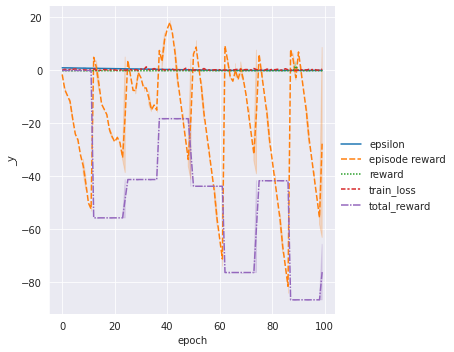

In [11]:
import pandas as pd
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")


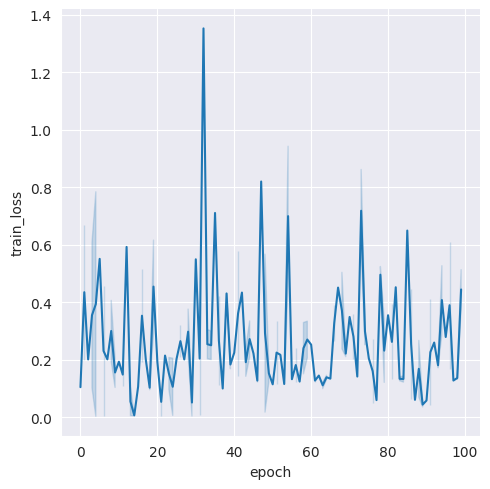

In [12]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics['train_loss'], kind="line")

In [13]:
model.agent.reset()
for i in range(4):
    model.agent.play_render(model.net)

Track generation: 1173..1471 -> 298-tiles track


/home/vlad/ITMORL/ITMO-RL-env/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Track generation: 1103..1383 -> 280-tiles track
Track generation: 1085..1360 -> 275-tiles track
Track generation: 1090..1366 -> 276-tiles track
Track generation: 1114..1397 -> 283-tiles track
